# Classify the tiles using pretrained tile2vec
In this notebook we are going to measure the performance of classifier on EuroSATallbands dataset.

In [1]:
import numpy as np
import os
import torch
from time import time
from torch.autograd import Variable
import random


import sys
sys.path.append('../')
from src.tilenet import make_tilenet
from src.resnet import ResNet18
import pandas as pd
from pathlib import Path
from osgeo import gdal

# sample tiles
In order to train the

In [30]:
sample_tiles_train_path = Path("/storage/EuroSATallBands/train.csv")
train_paths = pd.read_csv(sample_tiles_train_path)

base_eurosat_dir = Path("/storage/EuroSATallBands")

train_paths

,Filename,Label,ClassName
0,PermanentCrop/PermanentCrop_2401.tif,6,PermanentCrop
1,PermanentCrop/PermanentCrop_1006.tif,6,PermanentCrop
2,HerbaceousVegetation/HerbaceousVegetation_1025...,2,HerbaceousVegetation
3,SeaLake/SeaLake_1439.tif,9,SeaLake
4,River/River_1052.tif,8,River
...,...,...,...
19312,HerbaceousVegetation/HerbaceousVegetation_2292...,2,HerbaceousVegetation
19313,AnnualCrop/AnnualCrop_1226.tif,0,AnnualCrop
19314,SeaLake/SeaLake_2010.tif,9,SeaLake
19315,SeaLake/SeaLake_2291.tif,9,SeaLake


In [31]:
# create tiles

def get_triplet_imgs(img_df, n_triplets=1000):
    """
    Returns a numpy array of dimension (n_triplets, 2). First column is
    the img name of anchor/neighbor tiles and second column is img name 
    of distant tiles.
    """
    img_names = []
    for filename in img_df["Filename"]:
        img_names.append(filename)
    img_triplets = list(map(lambda _: random.choice(img_names), range(2 * n_triplets)))
    img_triplets = np.array(img_triplets)
    return img_triplets.reshape((-1, 2))

n_triplets = 20000

img_triplets = get_triplet_imgs(train_paths, n_triplets=n_triplets)
img_triplets

array([['SeaLake/SeaLake_506.tif', 'AnnualCrop/AnnualCrop_2733.tif'],
       ['Industrial/Industrial_56.tif', 'Forest/Forest_2590.tif'],
       ['Pasture/Pasture_850.tif', 'AnnualCrop/AnnualCrop_2066.tif'],
       ...,
       ['Forest/Forest_261.tif', 'Forest/Forest_2860.tif'],
       ['Pasture/Pasture_1697.tif', 'Pasture/Pasture_1637.tif'],
       ['Residential/Residential_87.tif', 'SeaLake/Jakarta_000131.tif']],
      dtype='<U50')

In [32]:
from src.sample_tiles import extract_tile, sample_distant_same, sample_neighbor, load_img, sample_anchor, sample_distant_diff
import tqdm

In [35]:

def get_triplet_tiles(tile_dir, img_dir, img_triplets, tile_size=50, neighborhood=100, 
                      val_type='uint8', bands_only=False, save=True, verbose=False):
    if not os.path.exists(tile_dir):
        os.makedirs(tile_dir)
    size_even = (tile_size % 2 == 0)
    tile_radius = tile_size // 2

    n_triplets = img_triplets.shape[0]
    unique_imgs = np.unique(img_triplets)
    tiles = np.zeros((n_triplets, 3, 2), dtype=np.int16)

    for img_name in tqdm(unique_imgs):
        if img_name[-3:] == 'npy':
            img = np.load(os.path.join(img_dir, img_name))
        else:
            img = load_img(os.path.join(img_dir, img_name), val_type=val_type, 
                       bands_only=bands_only)
        img_padded = np.pad(img, pad_width=[(tile_radius, tile_radius),
                                            (tile_radius, tile_radius), (0,0)],
                            mode='reflect')
        img_shape = img_padded.shape

        for idx, row in enumerate(img_triplets):
            if row[0] == img_name:
                xa, ya = sample_anchor(img_shape, tile_radius)
                xn, yn = sample_neighbor(img_shape, xa, ya, neighborhood, tile_radius)
                
                if verbose:
                    print("    Saving anchor and neighbor tile #{}".format(idx))
                    print("    Anchor tile center:{}".format((xa, ya)))
                    print("    Neighbor tile center:{}".format((xn, yn)))
                if save:
                    tile_anchor = extract_tile(img_padded, xa, ya, tile_radius)
                    tile_neighbor = extract_tile(img_padded, xn, yn, tile_radius)
                    if size_even:
                        tile_anchor = tile_anchor[:-1,:-1]
                        tile_neighbor = tile_neighbor[:-1,:-1]
                    np.save(os.path.join(tile_dir, '{}anchor.npy'.format(idx)), tile_anchor)
                    np.save(os.path.join(tile_dir, '{}neighbor.npy'.format(idx)), tile_neighbor)
                
                tiles[idx,0,:] = xa - tile_radius, ya - tile_radius
                tiles[idx,1,:] = xn - tile_radius, yn - tile_radius
                
                if row[1] == img_name:
                    # distant image is same as anchor/neighbor image
                    xd, yd = sample_distant_same(img_shape, xa, ya, neighborhood, tile_radius)
                    if verbose:
                        print("    Saving distant tile #{}".format(idx))
                        print("    Distant tile center:{}".format((xd, yd)))
                    if save:
                        tile_distant = extract_tile(img_padded, xd, yd, tile_radius)
                        if size_even:
                            tile_distant = tile_distant[:-1,:-1]
                        np.save(os.path.join(tile_dir, '{}distant.npy'.format(idx)), tile_distant)
                    tiles[idx,2,:] = xd - tile_radius, yd - tile_radius
            
            elif row[1] == img_name: 
                # distant image is different from anchor/neighbor image
                xd, yd = sample_distant_diff(img_shape, tile_radius)
                if verbose:
                        print("    Saving distant tile #{}".format(idx))
                        print("    Distant tile center:{}".format((xd, yd)))
                if save:
                    tile_distant = extract_tile(img_padded, xd, yd, tile_radius)
                    if size_even:
                        tile_distant = tile_distant[:-1,:-1]
                    np.save(os.path.join(tile_dir, '{}distant.npy'.format(idx)), tile_distant)
                tiles[idx,2,:] = xd - tile_radius, yd - tile_radius
            
    return tiles

In [36]:
# save the triplets
tile_dir = "/storage/tile2vec/tiles"

tiles = get_triplet_tiles(tile_dir, base_eurosat_dir, img_triplets)

  0%|          | 0/16864 [00:00<?, ?it/s]

  2%|▏         | 349/16864 [02:50<2:14:45,  2.04it/s]


KeyboardInterrupt: 

## train the new model

In [6]:
from src.datasets import TileTripletsDataset, GetBands, RandomFlipAndRotate, ClipAndScale, ToFloatTensor, triplet_dataloader
from src.tilenet import make_tilenet
from src.training import prep_triplets, train_triplet_epoch
from torch import optim

In [15]:
# Setting up model
in_channels = 13
z_dim = 512
# Environment stuff
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()
cuda

True

In [12]:
img_type = "naip" #images are in float - this parameter specifies that there is a need for normalization of floats
tile_dir = '/storage/tile2vec/tiles'
bands = 13
augment = True
batch_size = 50
shuffle = True
num_workers = 4
n_triplets = 10000

In [48]:
dataloader = triplet_dataloader(img_type, tile_dir, bands=bands, augment=augment,
                                batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, 
                                n_triplets=n_triplets, pairs_only=True)
print('Dataloader set up complete.')

Dataloader set up complete.


In [13]:
in_channels = bands 
z_dim = 512 # output dim

In [50]:
TileNet = make_tilenet(in_channels=in_channels, z_dim=z_dim)
TileNet.train()
if cuda: TileNet.cuda()
print('TileNet set up complete.')

TileNet set up complete.


In [51]:
cuda

True

In [52]:
lr = 1e-3
optimizer = optim.Adam(TileNet.parameters(), lr=lr, betas=(0.5, 0.999))

## training

In [3]:
epochs = 1
margin = 10
l2 = 0.01
print_every = 100
save_models = False

In [4]:
model_dir = '/storage/tile2vec/models'
if not os.path.exists(model_dir): 
    os.makedirs(model_dir)

In [55]:
results_fn = "/storage/tile2vec/results_fn"

In [56]:
t0 = time()
with open(results_fn, 'w') as file:

    print('Begin training.................')
    for epoch in range(0, epochs):
        (avg_loss, avg_l_n, avg_l_d, avg_l_nd) = train_triplet_epoch(
            TileNet, cuda, dataloader, optimizer, epoch+1, margin=margin, l2=l2,
            print_every=print_every, t0=t0)
        

# Save model after last epoch
if save_models:
    model_fn = os.path.join(model_dir, 'TileNet_simple.ckpt')
    torch.save(TileNet.state_dict(), model_fn)

Begin training.................
Epoch 1: [100/10000 (1%)], Avg loss: 13.2556
Epoch 1: [200/10000 (2%)], Avg loss: 10.3975
Epoch 1: [300/10000 (3%)], Avg loss: 10.8796
Epoch 1: [400/10000 (4%)], Avg loss: 9.4840
Epoch 1: [500/10000 (5%)], Avg loss: 9.1382
Epoch 1: [600/10000 (6%)], Avg loss: 8.5421
Epoch 1: [700/10000 (7%)], Avg loss: 7.9467
Epoch 1: [800/10000 (8%)], Avg loss: 8.2988
Epoch 1: [900/10000 (9%)], Avg loss: 8.0421
Epoch 1: [1000/10000 (10%)], Avg loss: 7.6982
Epoch 1: [1100/10000 (11%)], Avg loss: 7.6270
Epoch 1: [1200/10000 (12%)], Avg loss: 8.0049
Epoch 1: [1300/10000 (13%)], Avg loss: 8.9993
Epoch 1: [1400/10000 (14%)], Avg loss: 6.9339
Epoch 1: [1500/10000 (15%)], Avg loss: 7.9396
Epoch 1: [1600/10000 (16%)], Avg loss: 6.8229
Epoch 1: [1700/10000 (17%)], Avg loss: 8.8813
Epoch 1: [1800/10000 (18%)], Avg loss: 9.2595
Epoch 1: [1900/10000 (19%)], Avg loss: 6.5781
Epoch 1: [2000/10000 (20%)], Avg loss: 7.3226
Epoch 1: [2100/10000 (21%)], Avg loss: 8.3341
Epoch 1: [2200/10

# Convert validation and training set to numpy


In [18]:
from pathlib import Path
from tqdm import tqdm
from src.data_utils import clip_and_scale_image
validation_df = pd.read_csv("/storage/EuroSATallBands/validation.csv")
validation_path = Path("/storage/tile2vec/tif/val")
n_val_tiles = len(validation_df)

In [74]:



# this solution to iterate over examples is very suboptimal, one should use torch dataset
for index, row in tqdm(validation_df.iterrows(), total=n_val_tiles):
    # read the tile from provided filepath
    
    tile_filepath = base_eurosat_dir / row["Filename"]
    obj = gdal.Open(tile_filepath)
    img = obj.ReadAsArray().astype(np.float32)
    img = np.moveaxis(img, 0, -1)

    tile = img[:, :, :bands] 

    tile = np.moveaxis(tile, -1, 0)
    tile = np.expand_dims(tile, axis=0)

    tile = clip_and_scale_image(tile, img_type="landsat")
    np.save(validation_path / f"{index}.npy", tile)

t1 = time()

100%|██████████| 5519/5519 [00:07<00:00, 703.59it/s]


In [72]:
test_df = pd.read_csv("/storage/EuroSATallBands/test.csv")
test_path = Path("/storage/tile2vec/tif/test")
n_tiles = len(test_df)


for index, row in tqdm(test_df.iterrows(), total=n_tiles):
    # read the tile from provided filepath
    
    tile_filepath = base_eurosat_dir / row["Filename"]
    obj = gdal.Open(tile_filepath)
    img = obj.ReadAsArray().astype(np.float32)
    img = np.moveaxis(img, 0, -1)

    tile = img[:, :, :bands] 

    tile = np.moveaxis(tile, -1, 0)
    tile = np.expand_dims(tile, axis=0)

    tile = clip_and_scale_image(tile, img_type="landsat")
    np.save(test_path / f"{index}.npy", tile)

t1 = time()

100%|██████████| 2759/2759 [00:03<00:00, 792.18it/s] 


In [84]:
# check the single tile
np.max(tile.squeeze(), axis = (1,2))

array([0.1447, 0.1426, 0.1506, 0.1957, 0.2076, 0.3495, 0.4181, 0.3937,
       0.0662, 0.0013, 0.4336, 0.2645, 0.444 ], dtype=float32)

## simple embedding

In [ ]:
class ClipAndScale(object):
    """
    Clips and scales bands to between [0, 1] for NAIP, RGB, and Landsat
    satellite images. Clipping applies for Landsat only.
    """
    def __init__(self, img_type):
        assert img_type in ['naip', 'rgb', 'landsat']
        self.img_type = img_type

    def __call__(self, sample):
        sample = clip_and_scale_image(sample, self.img_type)
        return sample

class ToFloatTensor(object):
    """
    Converts numpy arrays to float Variables in Pytorch.
    """
    def __call__(self, sample):
        sample = torch.from_numpy(sample).float()
        return sample

def get_test_tile_dataloader(tile_dir):
    transform_list = []
    transform_list.append(ClipAndScale)
    transform_list.append(ToFloatTensor)
    
    transform = transforms.Compose(transform_list)
    
    

In [3]:
# load model
import os
import torch

from src.tilenet import make_tilenet
model_dir = '/storage/tile2vec/models'

model_fn = os.path.join(model_dir, 'TileNet_default_clipping.ckpt')
bands = 13
z_dim = 512


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()

tilenet = make_tilenet(in_channels=bands, z_dim=z_dim)
if cuda: 
    tilenet.cuda()

checkpoint = torch.load(model_fn)
tilenet.load_state_dict(checkpoint)
tilenet.eval()

TileNet(
  (conv1): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [4]:
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from pathlib import Path

validation_path = Path("/storage/tile2vec/tif/val")
validation_df = pd.read_csv("/storage/EuroSATallBands/validation.csv")

n_val_tiles = len(validation_df)


X = np.zeros((n_val_tiles, z_dim))
t0 = time()
# this solution to iterate over examples is very suboptimal, one should use torch dataset
for index in tqdm(range(n_val_tiles)):
    # read the tile from provided filepath
       
    tile = np.load(validation_path / f"{index}.npy")  
    tile = torch.from_numpy(tile).float()
    tile = (tile)
    if cuda: 
        tile = tile.cuda()
    z = tilenet.encode(tile)
    if cuda: 
        z = z.cpu()
    z = z.data.numpy()
    
    X[index,:] = z

t1 = time()
print('Embedded {} tiles: {:0.3f}s'.format(n_val_tiles, t1-t0))

  0%|          | 0/5519 [00:00<?, ?it/s]

 74%|███████▍  | 4078/5519 [00:15<00:04, 290.19it/s]

In [6]:
y = validation_df["Label"]

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_tr, y_tr)
y_pr = rf.predict(X_te)
acc = rf.score(X_te, y_te)

print(f"Model accuracy: {acc}")

Model accuracy: 0.490036231884058


In [13]:
from sklearn.metrics import f1_score

f1_score(y_te, y_pr, average='weighted')


0.4812561090423654

Text(0.5, 1.0, 'Heatmap of predictions')

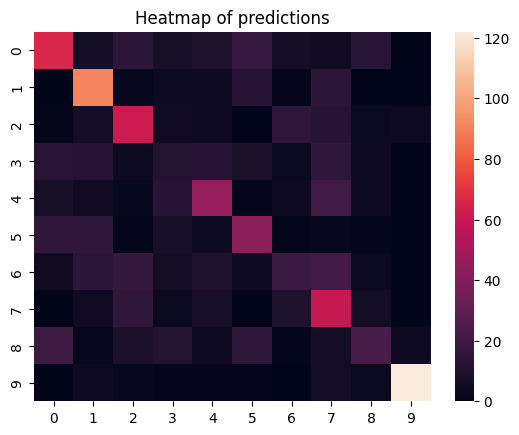

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix(y_te, y_pr)


sns.heatmap(confusion_matrix(y_te, y_pr))
plt.title("Heatmap of predictions")